In [2]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_train_G3tdtEn.csv')
test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_test_8skS2ey.csv')
data_Y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/Y_train_2_XPXJDyy.csv')

df = dataframe.copy()

## change of the categorical data to numbers

list_uniqueLabel = []
list_col_object = []
list_dic_map = []
# Loop for that assign a each unique categorical value a number and after it reeplace the categorical value for this number
for col in df.columns:
    if df[col].dtypes == object:
        list_col_object.append(col)


for count in range(0,4):

    concate = pd.concat([dataframe[colum] for colum in list_col_object[(count*24):((count+1)*24)]])
    concate = pd.concat([test_Dataframe[columt] for columt in list_col_object[(count*24):((count+1)*24)]])
    concate = pd.concat([pd.Series([np.nan]),concate])

    list_uniqueLabel.append(concate.unique())

    # dictionary
    dic_map = {label : index for index, label in enumerate(list_uniqueLabel[-1])}

    # Replace the values in dataframe

    for colob in range(0,24):
        df[list_col_object[colob+count*24]] = df[list_col_object[colob+count*24]].map(dic_map)

    list_dic_map.append(dic_map.copy())
    dic_map.clear()


<ipython-input-4-7221667b0216>:1: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_train_G3tdtEn.csv')
<ipython-input-4-7221667b0216>:2: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_test_8skS2ey.csv')


In [5]:
# Reemplace the 0 in the converted columns to his true value NaN
df[list_col_object] = df[list_col_object].replace(0,np.nan)

# Verification exact coincidence

exact_coincidence = (df['ID'] == data_Y['ID']).all()
print(exact_coincidence)

# we put out the columns that not contribute to the prediction

df = df.drop('ID',axis=1)
data_Y = data_Y.drop(['index','ID'], axis=1)

True


In [6]:
dataX = np.array(df)
dataY = np.array(data_Y)

print(dataX.shape)
print(dataY.shape)

print(np.sum(np.isnan(dataX)))

(92790, 145)
(92790, 1)
12415322


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Remplace the NaN values

constant_imputer = SimpleImputer(strategy='constant')
dataX_imp = constant_imputer.fit_transform(dataX)

# normalizacion

scaler = MinMaxScaler(feature_range=(0, 1))
dataX_n = scaler.fit_transform(dataX_imp)

# split of data for training and test

training_input_temp,test_input,training_output_temp,test_output = train_test_split(dataX_n, dataY, test_size=0.1)
training_input_t,val_input,training_output_t,val_output = train_test_split(training_input_temp, training_output_temp, test_size=0.222)


In [8]:

unique_values, freq = np.unique(test_output, return_counts=True)

# Show results
print(f"Valor: {unique_values}, Frecuencia: {freq}")

Valor: [0 1], Frecuencia: [9145  134]


In [9]:
unique_values, freq = np.unique(val_output, return_counts=True)

# Show results
print(f"Valor: {unique_values}, Frecuencia: {freq}")

Valor: [0 1], Frecuencia: [18268   272]


In [10]:

# SMOTE tecnique (Syntetic geenration of data)

from imblearn.over_sampling import SMOTE

# Return to dataframe

df_train = pd.DataFrame(training_input_t,columns=df.columns)
datY_train = pd.DataFrame(training_output_t,columns=data_Y.columns)

# Aplication of SMOTE only in the training data (test is with the original values)

count_minoritary_class = len(datY_train[datY_train['fraud_flag'] == 1])
smote = SMOTE(sampling_strategy={1:(34*count_minoritary_class)}, random_state=42) # the {1:4} means have the class with label 1, 4 times, so increase 3 values

df_smote,data_y_smote = smote.fit_resample(df_train,datY_train)

# Print number each class
print('class distribution before SMOTE')
print(datY_train['fraud_flag'].value_counts())
print('\n')
print('class distribution after SMOTE')
print(data_y_smote['fraud_flag'].value_counts())

print(df_train.shape)
print(df_smote.shape)

# Conversion to array
dataX_a = np.array(df_smote)
dataY_a = np.array(data_y_smote)

# Determination of training data
training_input,training_output = dataX_a,dataY_a

class distribution before SMOTE
0    64058
1      913
Name: fraud_flag, dtype: int64


class distribution after SMOTE
0    64058
1    31042
Name: fraud_flag, dtype: int64
(64971, 145)
(95100, 145)


In [11]:
import tensorflow as tf

# Function to improve the learning rate

def adapt_learning_rate(epoch):
    lr=0.001
    if epoch>100:
        lr=0.0001
    if epoch>200:
        lr=0.00005
    if epoch>240:
        lr=0.00001
    if epoch>700:
        lr=0.000005

    return lr

my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [12]:
# Neural Network

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Network

model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(145,)))
model.add(Dense(100,activation='relu'))
model.add(Dense(200,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(250,activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(500,activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(250,activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(150,activation='relu'))
model.add(Dense(1,activation='sigmoid')) # Output

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               14600     
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 250)               50250     
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 500)               125500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0

In [13]:
from sklearn.metrics import average_precision_score

# Define the metric average_precision as a personalised function
def average_precision(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)

In [14]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[average_precision])

In [15]:
history1 = model.fit(training_input,training_output,batch_size=600,epochs=50,
                    shuffle=True,callbacks=my_lr_scheduler,validation_data=(val_input,val_output))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


151/159 [===========================>..] - ETA: 0s - loss: 0.5505 - average_precision: 0.5604

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


159/159 [==============================] - 7s 8ms/step - loss: 0.5487 - average_precision: 0.5639 - val_loss: 0.3831 - val_average_precision: 0.0723 - lr: 0.0010
Epoch 2/50
159/159 [==============================] - 1s 7ms/step - loss: 0.4967 - average_precision: 0.6451 - val_loss: 0.3461 - val_average_precision: 0.0853 - lr: 0.0010
Epoch 3/50
159/159 [==============================] - 2s 11ms/step - loss: 0.4814 - average_precision: 0.6625 - val_loss: 0.3720 - val_average_precision: 0.0937 - lr: 0.0010
Epoch 4/50
159/159 [==============================] - 2s 10ms/step - loss: 0.4686 - average_precision: 0.6805 - val_loss: 0.3217 - val_average_precision: 0.0920 - lr: 0.0010
Epoch 5/50
159/159 [==============================] - 2s 10ms/step - loss: 0.4567 - average_precision: 0.6934 - val_loss: 0.3471 - val_average_precision: 0.0916 - lr: 0.0010
Epoch 6/50
159/159 [==============================] - 1s 7ms/step - loss: 0.4466 - average_precision: 0.7071 - val_loss: 0.4002 - val_average_p

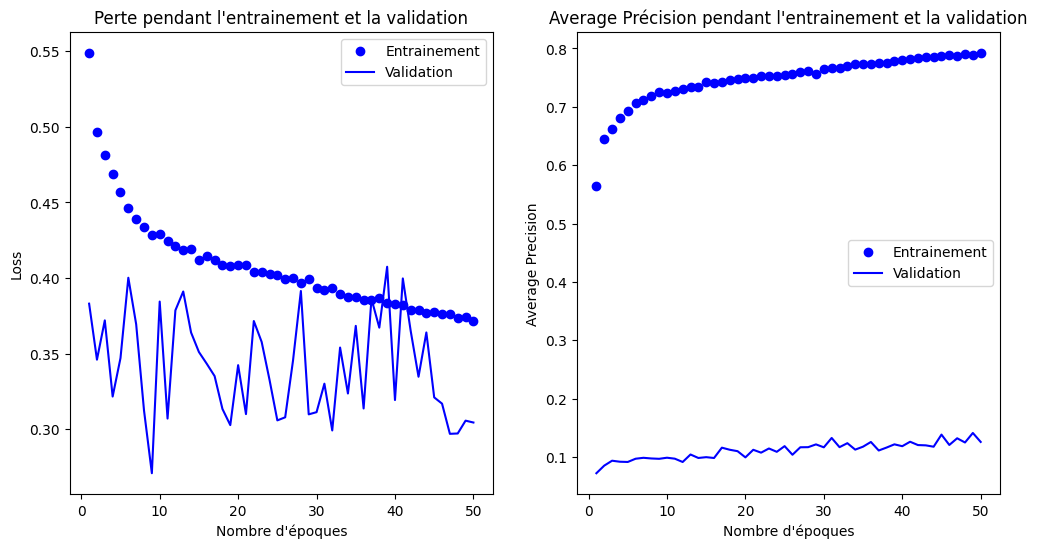

In [16]:
# Visualization of the model

import matplotlib.pyplot as plt

# plot fonction perte

loss=history1.history['loss']

val_loss = history1.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label = 'Entrainement')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Perte pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Loss')
plt.legend()

# plot precision du model

avp = history1.history['average_precision']
val_avp = history1.history['val_average_precision']

plt.subplot(1,2,2)
plt.plot(epochs,avp,'bo',label='Entrainement')
plt.plot(epochs, val_avp, 'b', label='Validation')
plt.title('Average Précision pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Average Precision')
plt.legend()
plt.savefig('loss_accuracy_model.jpg')
plt.show()

In [17]:
# Validation of model performance with new data

y_pred = model.predict(test_input)

counter_p = len([valor for valor in y_pred if valor > 0.5])
counter_r = len([valor_r for valor_r in test_output if valor_r > 0.5])
print('There are ',counter_p, ' labels (1) predicted')
print('There are ',counter_r, ' labels (1) in the reality')

print('Neural Network PR-AUC = ',average_precision_score(test_output,y_pred))

290/290 [==============================] - 1s 2ms/step
There are  1069  labels (1) predicted
There are  134  labels (1) in the reality
Neural Network PR-AUC =  0.08246460104576724


Training with all the data

In [18]:
training_input = np.vstack((training_input,val_input))
training_output = np.vstack((training_output,val_output))

In [19]:
history1 = model.fit(training_input,training_output,batch_size=600,epochs=50,
                    shuffle=True,callbacks=my_lr_scheduler)

Epoch 1/50
190/190 [==============================] - 1s 6ms/step - loss: 0.3624 - average_precision: 0.7506 - lr: 0.0010
Epoch 2/50
190/190 [==============================] - 1s 6ms/step - loss: 0.3571 - average_precision: 0.7547 - lr: 0.0010
Epoch 3/50
190/190 [==============================] - 1s 6ms/step - loss: 0.3562 - average_precision: 0.7539 - lr: 0.0010
Epoch 4/50
190/190 [==============================] - 1s 6ms/step - loss: 0.3529 - average_precision: 0.7583 - lr: 0.0010
Epoch 5/50
190/190 [==============================] - 1s 6ms/step - loss: 0.3566 - average_precision: 0.7551 - lr: 0.0010
Epoch 6/50
190/190 [==============================] - 1s 6ms/step - loss: 0.3527 - average_precision: 0.7593 - lr: 0.0010
Epoch 7/50
190/190 [==============================] - 1s 6ms/step - loss: 0.3514 - average_precision: 0.7606 - lr: 0.0010
Epoch 8/50
190/190 [==============================] - 2s 9ms/step - loss: 0.3528 - average_precision: 0.7590 - lr: 0.0010
Epoch 9/50
190/190 [====

TRATMENT OF THE TEST DATA

In [20]:
test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_test_8skS2ey.csv')
test = test_Dataframe.copy()

# Loop for that assign a each unique categorical value a number and after it reeplace the categorical value for this number

for count_1 in range(0,4):

    # dictionary
    dic_map_1 = list_dic_map[count_1]

    # Replace the values in dataframe

    for colob_1 in range(0,24):
        test[list_col_object[colob_1+count_1*24]] = test[list_col_object[colob_1+count_1*24]].map(dic_map_1)

<ipython-input-20-ca161c5edde8>:1: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_test_8skS2ey.csv')


In [21]:
# Reemplace the 0 in the converted columns to his true value NaN
test[list_col_object] = test[list_col_object].replace(0,np.nan)

# we put out the columns that not contribute to the prediction
test = test.drop('ID',axis=1)

In [22]:
dataX = np.array(test)

print(dataX.shape)

print(np.sum(np.isnan(dataX)))

(23198, 145)
3095028


In [23]:
# Remplace the NaN values

constant_imputer = SimpleImputer(strategy='constant')
dataX_imp = constant_imputer.fit_transform(dataX)

# normalizacion

scaler = MinMaxScaler(feature_range=(0, 1))
dataX_test = scaler.fit_transform(dataX_imp)

PREDICTION AND GENERATION OF THE Y TEST

In [24]:
# Prediction

y_pred = model.predict(dataX_test)

counter_p = len([valor for valor in y_pred if valor > 0.5])
print('There are ',counter_p, ' labels (1) predicted')

Y_test = pd.DataFrame(np.column_stack([test_Dataframe['ID'],y_pred]),columns=['ID','fraud_flag'])
Y_test.to_csv('Y_test.csv', index=True,index_label='index')
print(y_pred)

725/725 [==============================] - 2s 2ms/step
There are  986  labels (1) predicted
[[1.1603824e-04]
 [1.0507968e-04]
 [2.0072751e-01]
 ...
 [3.8464025e-03]
 [4.0436225e-06]
 [4.4987777e-01]]
